In [68]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.style.use({'figure.facecolor':'white'})

(1600000,) (1600000, 5)


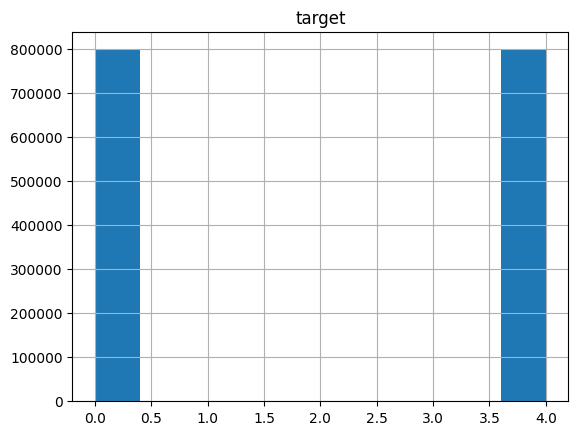

In [69]:
import pandas as pd

data = pd.read_csv('./dataset.csv', encoding = "ISO-8859-1", header=None, names=['target', 'id', 'date', 'flag', 'user', 'text'])
data.hist(column='target')
outputs = data['target']
data = data.drop(columns=['target'])
print(outputs.shape, data.shape)

In [70]:
import re
mentions = filter(lambda x: bool(re.search(r"@\w+",x)), data['text'])
print('mentions',len(list(mentions)))
data['text'] = data['text'].transform( lambda x: re.sub(r"@\w+", '' ,x))

mentions 738493


(1280000,) (320000,) (1280000,) (320000,)


<AxesSubplot:>

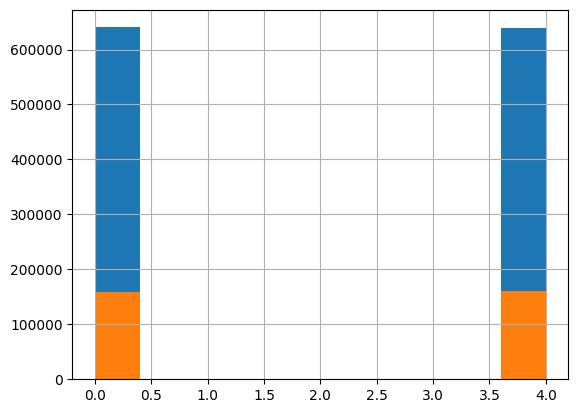

In [71]:
from sklearn.model_selection import train_test_split
x_train,y_test, x_label, y_label = train_test_split(data['text'],outputs, test_size=0.20, random_state=42)
print(x_train.shape, y_test.shape, x_label.shape, y_label.shape)
x_label.hist()
y_label.hist()

tokenize

In [72]:
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(strip_accents='ascii')),
    ('tfidf', TfidfTransformer()),
])

[nltk_data] Downloading package stopwords to /home/clovis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Too long
svm.SVC
Not work
GaussianNB

In [73]:
from sklearn import naive_bayes
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import PassiveAggressiveClassifier

classifiers = {"naive_bayes":
 Pipeline([ ('vect', CountVectorizer(strip_accents='ascii')),
    ('tfidf', TfidfTransformer()), ('clf', naive_bayes.MultinomialNB())]),
    "linear_model":
 Pipeline([ ('vect', CountVectorizer(strip_accents='ascii')),
    ('tfidf', TfidfTransformer()), ('clf', LinearSVC())]),
    "nearest_centroid":
 Pipeline([ ('vect', CountVectorizer(strip_accents='ascii')),
    ('tfidf', TfidfTransformer()), ('clf', NearestCentroid())]),
    "bernoulli":
 Pipeline([ ('vect', CountVectorizer(strip_accents='ascii')),
    ('tfidf', TfidfTransformer()), ('clf', BernoulliNB())]),
    "passive":
Pipeline([ ('vect', CountVectorizer(strip_accents='ascii')),
    ('tfidf', TfidfTransformer()), ('clf', PassiveAggressiveClassifier())])
}

testing classifiers

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from datetime import datetime
from train import train

train(x_train,x_label, y_test, y_label, classifiers)

naive_bayes classifier:
	Training...


testing ensemble classifiers

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline


estimators = [(k, v) for k, v in classifiers.items()]
ensemble = {
    "voting": Pipeline([('clf', VotingClassifier(estimators=estimators))]),
   # "adaboost": Pipeline([('clf', AdaBoostClassifier(base_estimator=classifiers['linear_model']))])
}

train(x_train,x_label, y_test, y_label, ensemble)

grids

In [ ]:
from sklearn.model_selection import GridSearchCV
grids = {
     "linear": Pipeline([('clf',GridSearchCV(estimator=classifiers['linear_model'],
             param_grid={'clf__penalty': ('l1', 'l2'), 'clf__dual': (True, False), 'clf__C': [1,10],
                         "clf__class_weight": ('dict', 'balanced', None),
                         "clf__multi_class": ('ovr', 'crammer_singer'),
                         }))]),
}
print(classifiers['linear_model'].get_params().keys())

for cls in grids:
    begin = datetime.now()
    print('grid search on ', cls, ' classifier')
    grids[cls].fit(x_train, x_label)
    print('time: ', datetime.now() - begin)
    print('params: ', grids[cls].cv_results_.keys())
    print('score: ', grids[cls].score(y_test, y_label))
    plot_confusion_matrix(grids[cls], y_test, y_label)
    plt.show()